#FaceVGG16: Caffe to Lasagne transcoding

In [1]:
import caffe
import cv2
import pandas as pd

import lasagne
from lasagne.layers import InputLayer, DropoutLayer, FlattenLayer, DenseLayer, NonlinearityLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.utils import floatX
from lasagne.nonlinearities import softmax
import theano.tensor as T
import theano
from collections import OrderedDict

import numpy as np

import cPickle as pickle

import matplotlib.pyplot as plt
%matplotlib inline  

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)
/usr/local/lib/python2.7/dist-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


Download the VGG16 Caffe model from the VGG page: http://www.robots.ox.ac.uk/~vgg/software/vgg_face/<br>
Extract it on a separate directory on the root directory of your project

In [4]:
net_caffe = caffe.Net('faceVGG16/VGG_FACE_deploy.prototxt',\
                      'faceVGG16/VGG_FACE.caffemodel', caffe.TEST)
peopleNames = pd.read_csv('faceVGG16/names.txt',header=None,names=['names'])

Create an empty VGG16 Lasagne model 

In [6]:
inputImage = T.tensor4()

net = OrderedDict()
net['input'] = InputLayer((None, 3, 224, 224), input_var=inputImage)
net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1)
net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1)
net['pool1'] = PoolLayer(net['conv1_2'], 2)
net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1)
net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1)
net['pool2'] = PoolLayer(net['conv2_2'], 2)
net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1)
net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1)
net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1)
net['pool3'] = PoolLayer(net['conv3_3'], 2)
net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1)
net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1)
net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1)
net['pool4'] = PoolLayer(net['conv4_3'], 2)
net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1)
net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1)
net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1)
net['pool5'] = PoolLayer(net['conv5_3'], 2)
net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=4096)
net['fc7_dropout'] = DropoutLayer(net['fc7'], p=0.5)
net['fc8'] = DenseLayer(net['fc7_dropout'], num_units=205, nonlinearity=None)
net['prob'] = NonlinearityLayer(net['fc8'], softmax)

Copy weights from the Caffe model into a the Lasange

In [7]:
layers_caffe = dict(zip(list(net_caffe._layer_names), net_caffe.layers))

for name, layer in net.items():
    try:
        if name.startswith('conv'):
            layer.W.set_value(layers_caffe[name].blobs[0].data)
            layer.b.set_value(layers_caffe[name].blobs[1].data)   
        else:
            layer.W.set_value(layers_caffe[name].blobs[0].data.T) # Transposed!!
            layer.b.set_value(layers_caffe[name].blobs[1].data)   
    except AttributeError:
        continue

Let's take a test image. Whichever you like but containing a "place" :)

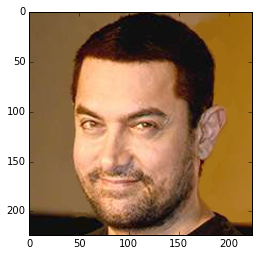

In [8]:
#Adjust color space and size to parse with the VGG
beach = cv2.resize( cv2.cvtColor( cv2.imread('faceVGG16/ak.png'), cv2.COLOR_BGR2RGB ), (224,224) )
plt.imshow(beach)

You can get this names from the matcaffe_demo.m file in the already downloaded tgz file

In [9]:
meanImg = np.array([[[ 93.5940 ]], [[ 104.7624 ]], [[ 129.1863 ]]])

Process the input image through Caffe

In [10]:
caffe.set_mode_gpu()
net_caffe.blobs['data'].data[...] = (beach.astype(theano.config.floatX).transpose(2,0,1) - meanImg)
outputCaffe = net_caffe.forward()

Classification results for Caffe

In [11]:
outputCaffeSorted = sorted(zip(list(outputCaffe['prob'][0]),range(255)), key=lambda x:x[0], reverse=True)

for k in outputCaffeSorted[:10]:
    print peopleNames.ix[k[1]]['names']

Aamir_Khan
Adam_Driver
Akshay_Kumar
Adrian_Paul
Adam_Copeland
Ajay_Devgn
Adam_Lambert
Adam_Garcia
Aidan_Turner
A.R._Rahman


Now, let's try to reproduce the same results with the transcoded model into Lasange.<br>
First, compile the functions in Lasagne

In [12]:
test_prediction = lasagne.layers.get_output(net['prob'], deterministic=True)
predictFunction = theano.function([inputImage], test_prediction)

In [13]:
dat = np.zeros((1,3,224,224)).astype(theano.config.floatX)
dat[0,...] = (beach.astype(theano.config.floatX).transpose(2,0,1) - meanImg)
outputLasagne = predictFunction(dat)

In [14]:
outputLasagneSorted = sorted(zip(list(outputLasagne[0]),range(255)), key=lambda x:x[0], reverse=True)

for k in outputLasagneSorted[:10]:
    print peopleNames.ix[k[1]]['names']

Aamir_Khan
Adam_Driver
Akshay_Kumar
Adrian_Paul
Adam_Copeland
Ajay_Devgn
Adam_Lambert
Adam_Garcia
Aidan_Turner
A.R._Rahman


<b>At this point, we conclude that the VGG16 Places transcoding from Caffe to Lasagne does produce the same results.</b>

For our experiments, we only need the convolutional part of the VGG16 model. We will be saving up to the 'pool5' layer in a pickle file.

In [15]:
modelToSave = {}

modelToSave['params'] = lasagne.layers.get_all_param_values(net['pool5'])
modelToSave['meanImg'] = meanImg
modelToSave['scaleFactor'] = 1.0

with open('ConvVGG_Faces.pkl', 'wb') as f:
    pickle.dump( modelToSave, f )